In [ ]:
pip install matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random


In [ ]:
from PIL import Image

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pip install numpy

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=855755b3a738b23057d3845906976d53d178392c89cf5dc4d051621bc8bae98c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
from tqdm import trange
import tqdm
from efficientnet_pytorch import EfficientNet

In [ ]:
!pip install torch torchvision timm
from timm import create_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
import numpy as np

Defining Transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 47221406.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
total_size = len(cifar_dataset)
pretrain_size = int(0.45 * total_size)
finetune_size = int(0.05 * total_size)
test_size = total_size - pretrain_size - finetune_size

# Split dataset into 5% for pre-training, 45% for fine-tuning, and 50% for testing, as specified in the task.
pretrain_dataset, remaining_dataset = random_split(cifar_dataset, [pretrain_size, total_size - pretrain_size])
finetune_dataset, test_dataset = random_split(remaining_dataset, [finetune_size, test_size])


Files already downloaded and verified


 To understand the effect  of supervised learning and pre-training, we need to compare the performance of the model at various stages.

 First of all, let us test the base capacity of our model. Let us see it's test accuracy without training it and see. This gives us an idea about the capability of the model in it's raw state and helps us compare with our results later. I have named this model "**model_empty**"

In [ ]:
model_empty = create_model('efficientnet_b6', pretrained=False)
num_classes_cifar10 = 10
model_empty.classifier = nn.Linear(in_features=2304, out_features=num_classes_cifar10, bias=True)


In [ ]:
batch_size = 128
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(test_dataset)

25000

In [ ]:
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_empty(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# This code block takes around 12 minutes to run


<function matplotlib.pyplot.show(close=None, block=None)>

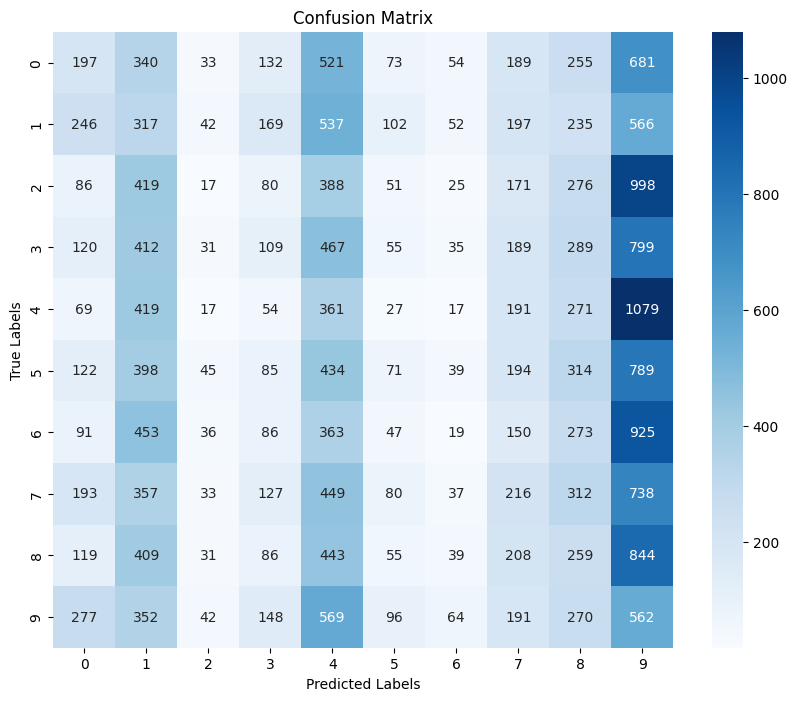

In [ ]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show

In [ ]:
predictions_np = np.array(predictions)
true_labels_np = np.array(true_labels)

# Calculate accuracy
accuracy_untrained = accuracy_score(true_labels_np, predictions_np)

In [ ]:
print(f'Test Accuracy for completely untrained model: {accuracy_untrained* 100:.5f}%')

Test Accuracy for completely untrained model: 8.51200%


If you blindfold a human being and ask them to perform 10-class classification, there is a 1 in 10 chance, they get it correct. An empty, untrained model can be compared to a blindfolded person, with no data whatsoever. Hence, we are ideally expecting a probability in the vicinity of 10% for a CIFAR-10 classification task.

Our results are consistent with this theory. On running the above code block several times, we achieved the following results
*   11.923%
*   9.812%
*   10.081%
*   8.512%





### Training and Testing, but no pre-training
Now, we will Train our model for the classification task on the 5%-finetune dataset, and test it on the remaining 50%. However, no pretraining will be done. Moreover, since we are training the model on a very small amount of data, a very high accuracy can not be expected.

EfficientNet model is being used, as mentioned in the problem statement.

In [ ]:
#here, we created dataloaders for all our datasets, to use them to train models
pretrain_loader = torch.utils.data.DataLoader(pretrain_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
finetune_loader = torch.utils.data.DataLoader(finetune_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
num_classes_cifar10 = 10

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=10)  # 10 classes in CIFAR-10
model.classifier = nn.Linear(in_features=2304, out_features=num_classes_cifar10, bias=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Loaded pretrained weights for efficientnet-b6


All experiments were initially carried out on my local PC using VSCode, however, were later shifted to Google Colab to gain GPU access.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
num_epochs = 5
model = model.to(device)

# Training loop on the train dataset
for epoch in trange(num_epochs):
    for inputs, labels in finetune_loader:
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation on the test dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy}')



100%|██████████| 5/5 [00:31<00:00,  6.21s/it]


Test Accuracy: 0.45048


In [ ]:
accuracy_percentage_nopre = accuracy * 100
print(f'Test Accuracy: {accuracy_percentage_nopre:.2f}%')

Test Accuracy: 45.05%


The accuracy seen above is on training the model on 5% of the dataset and then testing on the remaining 50%. We can see the significant, and obvious, increase in accuracy, considering that the model has been trained on labelled data.

#### Self-supervised Learning task.

Below, we start the jigsaw puzzle transformation. In the reference provided by the sustainability lab, it was suggested to segment the image into 9 pieces, but I have gone with a 4-piece, i.e, a 2x2 grid, in the interest of time. In the first code block, we are simply dividing the image into 4 parts, and saving every permutation of the shuffled images, alongside their labels, which will help in performing the self-supervised task.

In the website cited by the Sustainability Lab, Noorezi et al. suggest working with a Context-Free Network (CFN) for the SSL task. However, to maintain a fair comparison, I have done all the experiments on the "EfficientNet-B6" model.

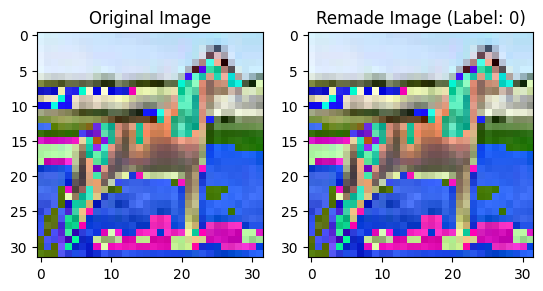

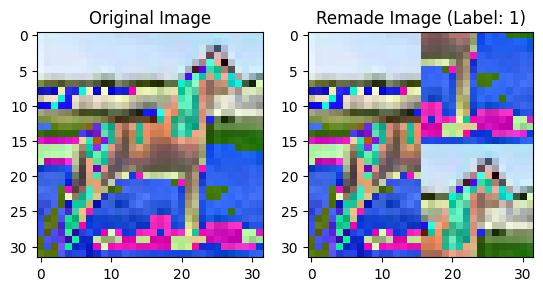

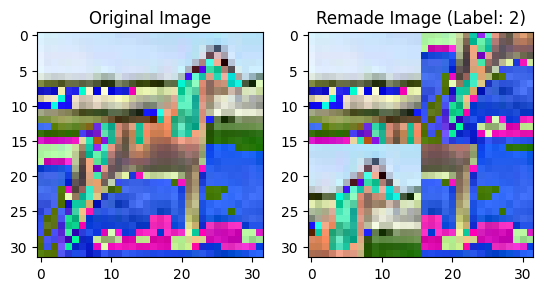

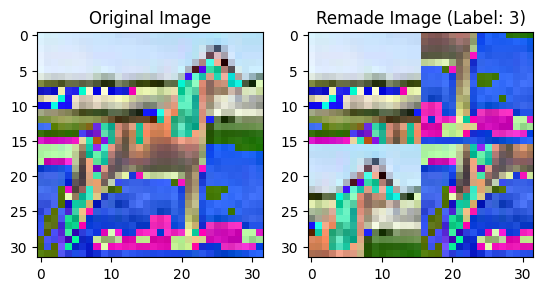

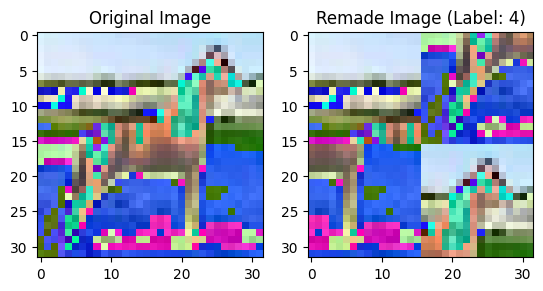

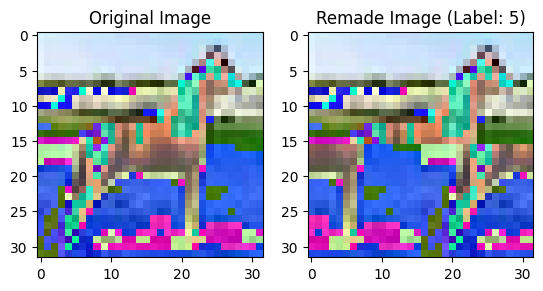

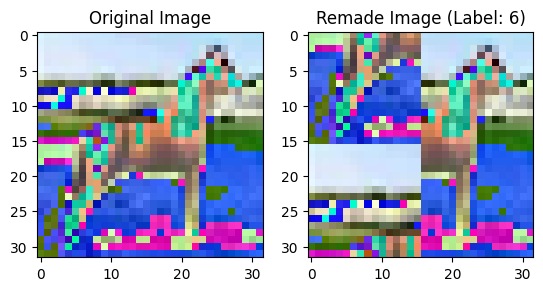

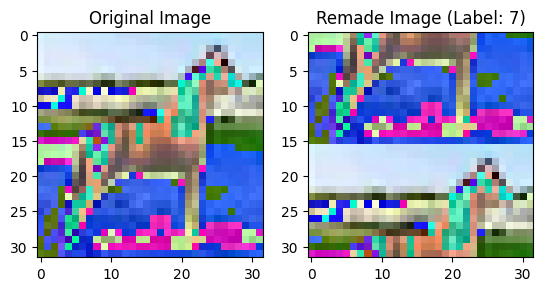

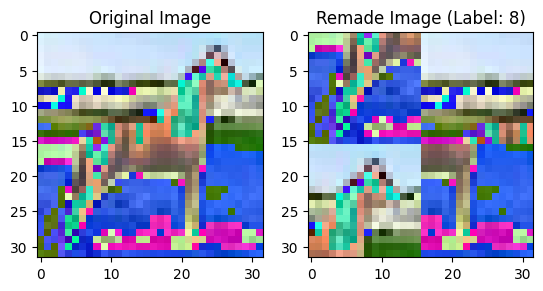

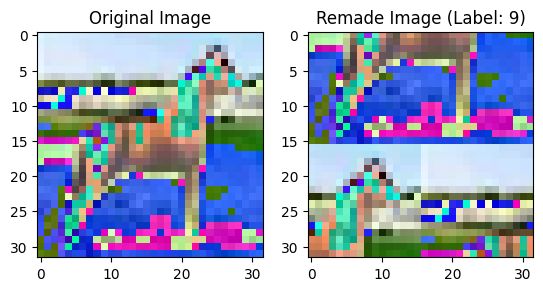

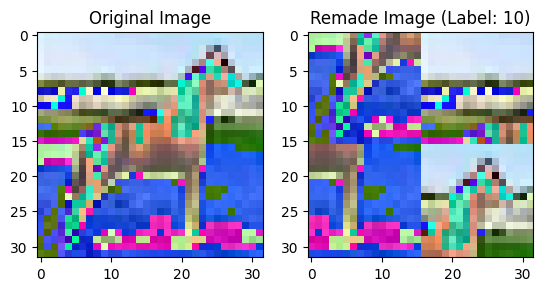

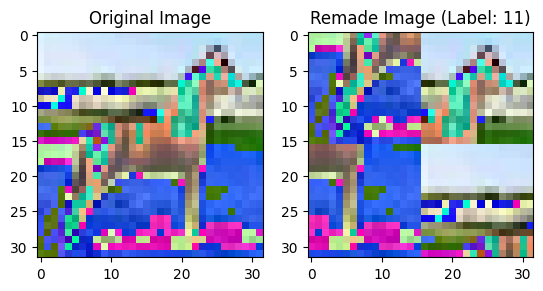

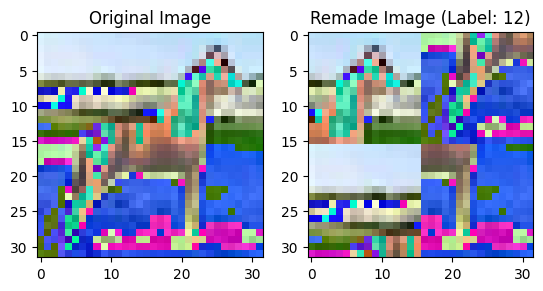

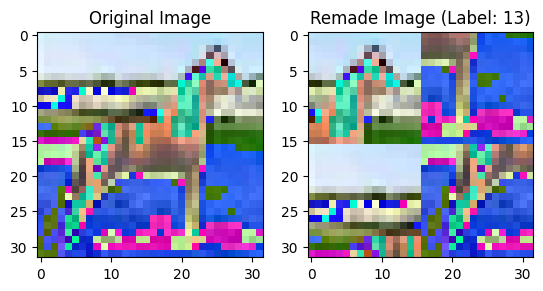

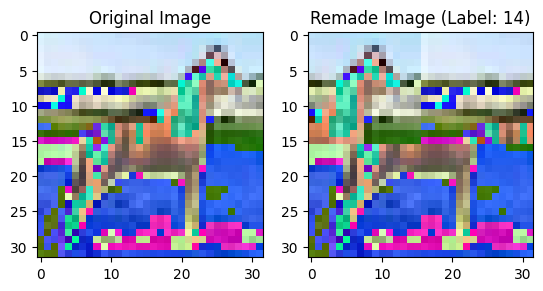

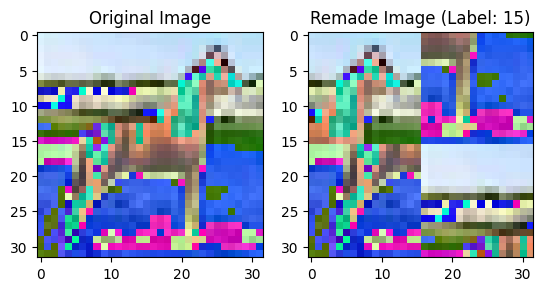

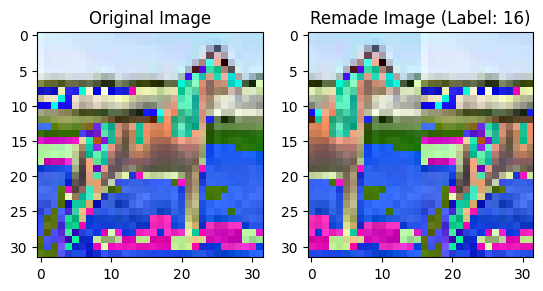

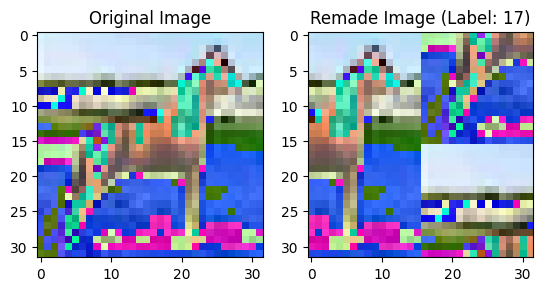

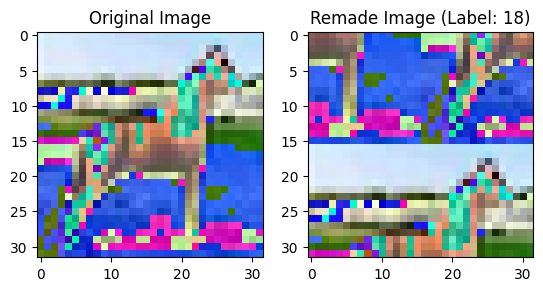

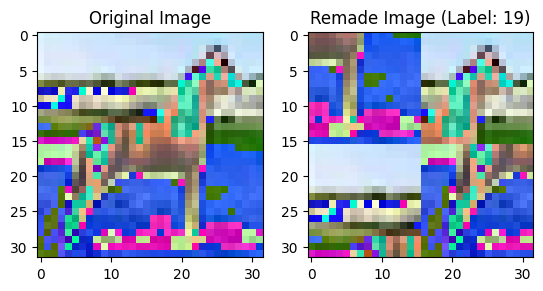

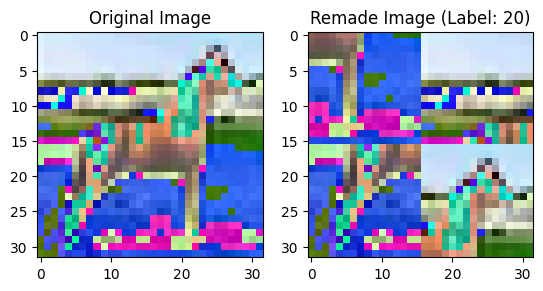

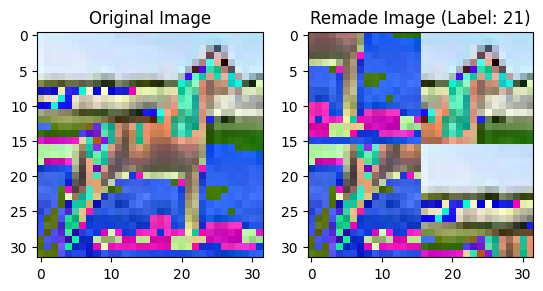

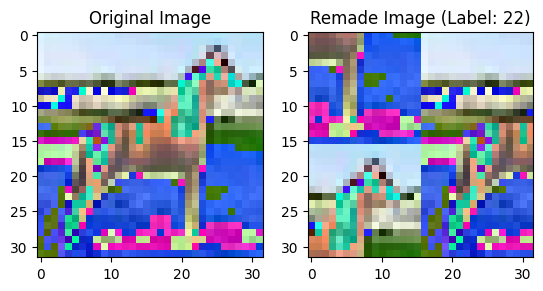

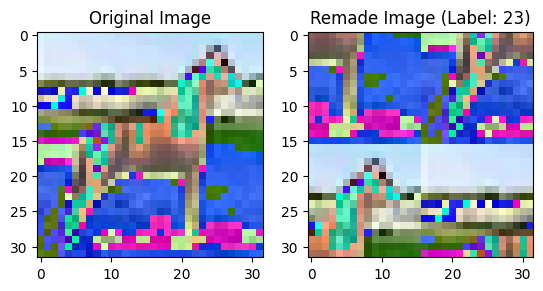

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools

bb = []
dd = []
label = [0, 1, 2, 3]
label_permute = list(itertools.permutations(label))
h = 32
w = 32

for img, _ in pretrain_dataset:
    c, h, w = img.shape
    img_part = np.zeros((4, c, h // 2, w // 2))
    img_part[0] = img[:, : h // 2, : w // 2]
    img_part[1] = img[:, h // 2 :, : w // 2]
    img_part[2] = img[:, : h // 2, w // 2 :]
    img_part[3] = img[:, h // 2 :, w // 2 :]

    for j, k in zip(label_permute, range(len(label_permute))):
        img_up = np.concatenate((img_part[j[0]], img_part[j[2]]), axis=2)
        img_down = np.concatenate((img_part[j[1]], img_part[j[3]]), axis=2)
        remade_image = np.concatenate((img_up, img_down), axis=1)

        remade_tensor = torch.tensor(remade_image, dtype=torch.float32)

        # Displaying original and remade images using matplotlib
        plt.subplot(121)
        plt.imshow((img.numpy() * 255).astype(np.uint8).transpose(1, 2, 0))
        plt.title("Original Image")

        #Displaying the remade image after the jigsaw puzzle transform, to check if the shuffling is happening as expected.
        plt.subplot(122)
        plt.imshow((remade_tensor.numpy() * 255).astype(np.uint8).transpose(1, 2, 0))
        plt.title(f"Remade Image (Label: {k})")

        plt.show()

        bb.append(remade_tensor)
        dd.append(torch.tensor(k))

    # Break out of the loop after processing the first image
    break


The below above block runs the jigsaw puzzle transformation and breaks after one iteration, to test if the permutations are happening as expected.

I shuffled the dataset and run this code block multiple times, over multiple images, and the relative order of the permutations also remains the same.(i.e, label = 0 is always 1234, label = 1 is always 1432 ... label = 23 is always 4321)

Now below, we run the same transformation over the entire pre-training dataset and store the images alongside their labels in the temporary lists bb and dd, which will later be put together into a dataset to pre-train our model on

In [ ]:
from tqdm import tqdm
import itertools
import numpy as np
from PIL import Image

bb = []
dd = []
label = [0,1,2,3]
label_permute = list(itertools.permutations(label))
h = 32
w = 32
for img, _ in pretrain_dataset:

        c, w, h = img.shape
        img_part = np.zeros((4, 3, h // 2, w // 2))
        img_part[0] = img[:, : h // 2, : w // 2]
        img_part[1] = img[:, h // 2 :, : w // 2]
        img_part[2] = img[:, : h // 2, w // 2 :]
        img_part[3] = img[:, h // 2 :, w // 2 :]

        for j,k in zip(label_permute, range(len(label_permute))):
            img_up = np.concatenate((img_part[j[0]], img_part[j[2]]), axis=2)
        # Combine the bottom-left and bottom-right parts
            img_down = np.concatenate((img_part[j[1]], img_part[j[3]]), axis=2)

        # Combine the top and bottom halves to create the final stitched image
            remade_image = np.concatenate((img_up, img_down), axis=1)
            pil_image = Image.fromarray((remade_image * 255).astype(np.uint8).transpose(1, 2, 0))

            bb.append(torch.tensor(remade_image, dtype=torch.float32))
            dd.append(torch.tensor(k))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#defining our own class, to use the lists we created in the SSL task for our downstream task
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([transforms.ToTensor()])

custom_dataset = CustomDataset(images=bb, labels=dd, transform=None)

In [ ]:
batch_size = 128
total_size = len(custom_dataset)

num_subsets = 9 #dividing the dataset into 9 parts, so that the Google Colab RAM capacity does not get exceeded
subset_size = total_size // num_subsets

indices = list(range(total_size))
subset_indices = [indices[i * subset_size:(i + 1) * subset_size] for i in range(num_subsets)]

subset_loaders = [] #creating dataloaders for each subset, will be filled sequentially
for i in range(num_subsets):
    subset_dataset = torch.utils.data.Subset(custom_dataset, subset_indices[i])
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

In [ ]:
subset_loaders[8] #check

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model_ssl = EfficientNet.from_pretrained('efficientnet-b6', num_classes=24)
model_ssl.classifier = nn.Linear(in_features=2304, out_features=24, bias=True) #since there are 24 permutations for every image

model_ssl.add_module('softmax', nn.Softmax(dim=1))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ssl.parameters(), lr=0.001)

model_ssl = model_ssl.to(device)


Loaded pretrained weights for efficientnet-b6


## Only SSL, No finetuning

In [ ]:
num_rounds = len(subset_loaders)
num_epochs = 1

all_losses = []

for epoch in trange(num_epochs):
    for round_num, data_loader in enumerate(subset_loaders):
        print(f"\nTraining Epoch {epoch + 1}/{num_epochs}, Round {round_num + 1} / {len(subset_loaders)}")

        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in data_loader:
            optimizer.zero_grad()
            outputs = model_ssl(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels.to(device)).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch-level metrics
        epoch_loss = total_loss / len(data_loader)
        epoch_accuracy = correct_predictions / total_samples

        # Display loss and accuracy after each epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Save the model weights after each epoch
    torch.save(model_ssl.state_dict(), f"model_weights_epoch_{epoch + 1}.pth")
    print(f"Model weights saved after Epoch {epoch + 1}")

    # Load the model weights before the next epoch
    model_ssl.load_state_dict(torch.load(f"model_weights_epoch_{epoch + 1}.pth"))
    model_ssl.to(device)

print("Training complete.")

  0%|          | 0/1 [00:00<?, ?it/s]


Training Epoch 1/1, Round 1 / 9
Epoch 1/1, Loss: 1.2896, Accuracy: 0.5950

Training Epoch 1/1, Round 2 / 9
Epoch 1/1, Loss: 0.2733, Accuracy: 0.9198

Training Epoch 1/1, Round 3 / 9
Epoch 1/1, Loss: 0.1997, Accuracy: 0.9433

Training Epoch 1/1, Round 4 / 9
Epoch 1/1, Loss: 0.1401, Accuracy: 0.9599

Training Epoch 1/1, Round 5 / 9
Epoch 1/1, Loss: 0.1122, Accuracy: 0.9677

Training Epoch 1/1, Round 6 / 9
Epoch 1/1, Loss: 0.1044, Accuracy: 0.9695

Training Epoch 1/1, Round 7 / 9
Epoch 1/1, Loss: 0.1002, Accuracy: 0.9708

Training Epoch 1/1, Round 8 / 9
Epoch 1/1, Loss: 0.0927, Accuracy: 0.9731

Training Epoch 1/1, Round 9 / 9
Epoch 1/1, Loss: 0.0924, Accuracy: 0.9745
Model weights saved after Epoch 1


100%|██████████| 1/1 [17:05<00:00, 1025.89s/it]

Training complete.


Here, we are running epoch-1 over all 9 subsets of the pretraining dataset. If num_epochs is increased, then the model would run over all the subsets from 1 to 9, for epoch 1, and then start over from subset 1 and go down to subset 9 again, for epoch 2.

We also recorded results by training sequentially, i.e, running multiple epochs on subset 1, then running multiple epochs on subset 2 and so forth.

All recorded results are mentioned at the end of this notebook.

In [ ]:
torch.save(model_ssl.state_dict(), '1epochs_e.pth')

In [ ]:
# Evaluation on the test dataset
model_ssl.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_ssl(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = correct / total
accuracy_percentage = accuracy * 100
print(f'Test Accuracy: {accuracy_percentage:.5f}%')


Test Accuracy: 9.56800%



The accuracy obtained above is when the model undergoes pre-training followed by direct testing, nothing else. We can see that the accuracy remains in the same range as that of the empty model.

This is because even though the model learns valuable semantic representation, it is learning nothing about the original labels of the data and their classification as per the CIFAR-10 dataset.

Now below, we will add a linear layer to make our model suitable for CIFAR-10 classification task. The model will carry forward the weights it has learned from the SSL task, and be further finetuned by training on the 5% finetune dataset.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

efficientnet_model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=24)  # Change num_classes to 24

#choose one of the below two statements, as required
state_dict_to_load = model_ssl.state_dict()
# state_dict_to_load = torch.load("/content/1epochs_e.pth")

efficientnet_model.load_state_dict(state_dict_to_load, strict=False)

efficientnet_model._fc = nn.Linear(in_features=2304, out_features=10, bias=True)

efficientnet_model.add_module('softmax', nn.Softmax(dim=1))

in_features = efficientnet_model._fc.in_features


Loaded pretrained weights for efficientnet-b6


Below we will define the architecture we want to replace the last layer of our EffNet architecture with.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model = efficientnet_model.to(device)

In [ ]:
from tqdm import trange
from efficientnet_pytorch import EfficientNet

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)



We use our modified model for the CIFAR-10 classification task below.

Epochs:   2%|▏         | 1/50 [00:07<06:04,  7.45s/it]

Epoch 1/50, Loss: 2.1541, Accuracy: 0.2072


Epochs:   4%|▍         | 2/50 [00:13<05:30,  6.88s/it]

Epoch 2/50, Loss: 1.6173, Accuracy: 0.4064


Epochs:   6%|▌         | 3/50 [00:20<05:12,  6.65s/it]

Epoch 3/50, Loss: 1.2309, Accuracy: 0.5436


Epochs:   8%|▊         | 4/50 [00:26<05:03,  6.60s/it]

Epoch 4/50, Loss: 0.9191, Accuracy: 0.6708


Epochs:  10%|█         | 5/50 [00:33<04:54,  6.53s/it]

Epoch 5/50, Loss: 0.6741, Accuracy: 0.7696


Epochs:  12%|█▏        | 6/50 [00:40<04:52,  6.64s/it]

Epoch 6/50, Loss: 0.4490, Accuracy: 0.8488


Epochs:  14%|█▍        | 7/50 [00:46<04:48,  6.70s/it]

Epoch 7/50, Loss: 0.3395, Accuracy: 0.8892


Epochs:  16%|█▌        | 8/50 [00:53<04:42,  6.73s/it]

Epoch 8/50, Loss: 0.2623, Accuracy: 0.9132


Epochs:  18%|█▊        | 9/50 [01:00<04:41,  6.86s/it]

Epoch 9/50, Loss: 0.2237, Accuracy: 0.9308


Epochs:  20%|██        | 10/50 [01:07<04:34,  6.85s/it]

Epoch 10/50, Loss: 0.1963, Accuracy: 0.9356


Epochs:  22%|██▏       | 11/50 [01:14<04:29,  6.90s/it]

Epoch 11/50, Loss: 0.1798, Accuracy: 0.9388


Epochs:  24%|██▍       | 12/50 [01:21<04:23,  6.92s/it]

Epoch 12/50, Loss: 0.1372, Accuracy: 0.9544


Epochs:  26%|██▌       | 13/50 [01:28<04:13,  6.85s/it]

Epoch 13/50, Loss: 0.1141, Accuracy: 0.9652


Epochs:  28%|██▊       | 14/50 [01:34<04:02,  6.74s/it]

Epoch 14/50, Loss: 0.1112, Accuracy: 0.9600


Epochs:  30%|███       | 15/50 [01:41<03:59,  6.83s/it]

Epoch 15/50, Loss: 0.0980, Accuracy: 0.9712


Epochs:  32%|███▏      | 16/50 [01:48<03:47,  6.68s/it]

Epoch 16/50, Loss: 0.0977, Accuracy: 0.9724


Epochs:  34%|███▍      | 17/50 [01:54<03:40,  6.69s/it]

Epoch 17/50, Loss: 0.0951, Accuracy: 0.9736


Epochs:  36%|███▌      | 18/50 [02:01<03:32,  6.64s/it]

Epoch 18/50, Loss: 0.0857, Accuracy: 0.9752


Epochs:  38%|███▊      | 19/50 [02:08<03:28,  6.72s/it]

Epoch 19/50, Loss: 0.0926, Accuracy: 0.9724


Epochs:  40%|████      | 20/50 [02:14<03:17,  6.59s/it]

Epoch 20/50, Loss: 0.0781, Accuracy: 0.9764


Epochs:  42%|████▏     | 21/50 [02:21<03:11,  6.61s/it]

Epoch 21/50, Loss: 0.0802, Accuracy: 0.9772


Epochs:  44%|████▍     | 22/50 [02:27<03:03,  6.56s/it]

Epoch 22/50, Loss: 0.0594, Accuracy: 0.9804


Epochs:  46%|████▌     | 23/50 [02:35<03:03,  6.79s/it]

Epoch 23/50, Loss: 0.0645, Accuracy: 0.9804


Epochs:  48%|████▊     | 24/50 [02:41<02:52,  6.64s/it]

Epoch 24/50, Loss: 0.0641, Accuracy: 0.9824


Epochs:  50%|█████     | 25/50 [02:48<02:46,  6.65s/it]

Epoch 25/50, Loss: 0.0641, Accuracy: 0.9788


Epochs:  52%|█████▏    | 26/50 [02:54<02:39,  6.63s/it]

Epoch 26/50, Loss: 0.0755, Accuracy: 0.9776


Epochs:  54%|█████▍    | 27/50 [03:01<02:33,  6.67s/it]

Epoch 27/50, Loss: 0.0650, Accuracy: 0.9832


Epochs:  56%|█████▌    | 28/50 [03:07<02:25,  6.61s/it]

Epoch 28/50, Loss: 0.0409, Accuracy: 0.9868


Epochs:  58%|█████▊    | 29/50 [03:14<02:18,  6.61s/it]

Epoch 29/50, Loss: 0.0443, Accuracy: 0.9856


Epochs:  60%|██████    | 30/50 [03:20<02:10,  6.53s/it]

Epoch 30/50, Loss: 0.0280, Accuracy: 0.9920


Epochs:  62%|██████▏   | 31/50 [03:27<02:06,  6.66s/it]

Epoch 31/50, Loss: 0.0376, Accuracy: 0.9876


Epochs:  64%|██████▍   | 32/50 [03:34<01:58,  6.57s/it]

Epoch 32/50, Loss: 0.0270, Accuracy: 0.9916


Epochs:  66%|██████▌   | 33/50 [03:40<01:51,  6.58s/it]

Epoch 33/50, Loss: 0.0278, Accuracy: 0.9900


Epochs:  68%|██████▊   | 34/50 [03:47<01:44,  6.50s/it]

Epoch 34/50, Loss: 0.0382, Accuracy: 0.9880


Epochs:  70%|███████   | 35/50 [03:53<01:38,  6.54s/it]

Epoch 35/50, Loss: 0.0292, Accuracy: 0.9896


Epochs:  72%|███████▏  | 36/50 [03:59<01:30,  6.46s/it]

Epoch 36/50, Loss: 0.0204, Accuracy: 0.9920


Epochs:  74%|███████▍  | 37/50 [04:07<01:28,  6.78s/it]

Epoch 37/50, Loss: 0.0220, Accuracy: 0.9932


Epochs:  76%|███████▌  | 38/50 [04:13<01:19,  6.62s/it]

Epoch 38/50, Loss: 0.0129, Accuracy: 0.9964


Epochs:  78%|███████▊  | 39/50 [04:20<01:12,  6.62s/it]

Epoch 39/50, Loss: 0.0255, Accuracy: 0.9932


Epochs:  80%|████████  | 40/50 [04:26<01:05,  6.52s/it]

Epoch 40/50, Loss: 0.0201, Accuracy: 0.9952


Epochs:  82%|████████▏ | 41/50 [04:33<00:59,  6.57s/it]

Epoch 41/50, Loss: 0.0265, Accuracy: 0.9928


Epochs:  84%|████████▍ | 42/50 [04:39<00:51,  6.48s/it]

Epoch 42/50, Loss: 0.0256, Accuracy: 0.9916


Epochs:  86%|████████▌ | 43/50 [04:46<00:45,  6.53s/it]

Epoch 43/50, Loss: 0.0232, Accuracy: 0.9940


Epochs:  88%|████████▊ | 44/50 [04:52<00:38,  6.49s/it]

Epoch 44/50, Loss: 0.0222, Accuracy: 0.9924


Epochs:  90%|█████████ | 45/50 [04:59<00:32,  6.54s/it]

Epoch 45/50, Loss: 0.0380, Accuracy: 0.9908


Epochs:  92%|█████████▏| 46/50 [05:05<00:25,  6.46s/it]

Epoch 46/50, Loss: 0.0414, Accuracy: 0.9904


Epochs:  94%|█████████▍| 47/50 [05:12<00:19,  6.50s/it]

Epoch 47/50, Loss: 0.0331, Accuracy: 0.9900


Epochs:  96%|█████████▌| 48/50 [05:18<00:12,  6.44s/it]

Epoch 48/50, Loss: 0.0243, Accuracy: 0.9924


Epochs:  98%|█████████▊| 49/50 [05:25<00:06,  6.48s/it]

Epoch 49/50, Loss: 0.0292, Accuracy: 0.9904


Epochs: 100%|██████████| 50/50 [05:31<00:00,  6.63s/it]

Epoch 50/50, Loss: 0.0391, Accuracy: 0.9908


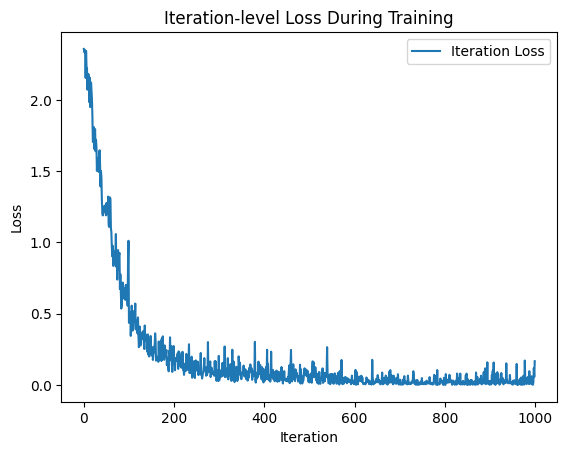

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange

num_epochs = 50
iteration_losses = []  # List to store iteration-level losses

# Training loop on the train dataset
for epoch in trange(num_epochs, desc='Epochs'):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for iteration, (inputs, labels) in enumerate(finetune_loader, 1):
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        iteration_losses.append(loss.item())  # Store iteration-level loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.to(device)).sum().item()
        total_samples += labels.size(0)

        # Print or log iteration-level loss
        if iteration % 100 == 0:  # Adjust frequency of printing as needed
            print(f"Iteration {iteration}, Loss: {loss.item():.4f}")

    # Calculate epoch-level metrics
    epoch_loss = total_loss / len(finetune_loader)
    epoch_accuracy = correct_predictions / total_samples

    # Display loss and accuracy after each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot iteration-level loss
plt.plot(iteration_losses, label='Iteration Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration-level Loss During Training')
plt.legend()
plt.show()


The clear convergence of the Loss vs Iteration curve shows that the model is being trained well, and could potentially yield good results.

In [ ]:
efficientnet_model.eval()
correct = 0
total = 0

predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy*100}')

Test Accuracy: 62.2


<function matplotlib.pyplot.show(close=None, block=None)>

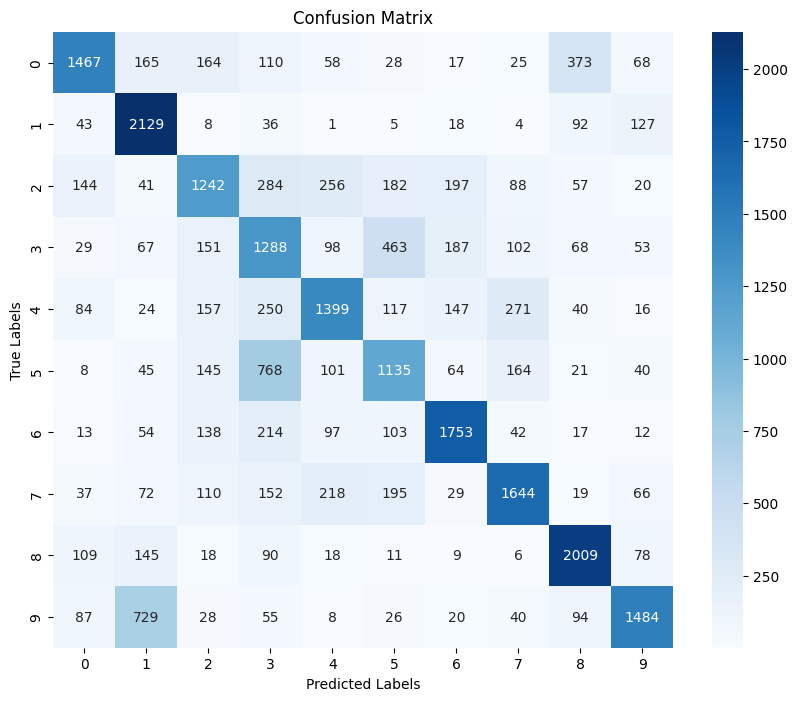

In [ ]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show

At the end, we can see that there is a significant increase in the accuracy of the model, on performing the SSL task followed by finetuning. I do believe that better results can be obtained by further experimenting with the hyperparameters such as the learning rate and the number of epochs.

*(Note:- I was expecting to gain better accuracy on increasing the number of SSL epochs, but this did not stand true on experimenting.)*

The final results are:


*   Empty Model : 8.512%
*   Training and Testing - No Pretraining : 45.05%
*   SSL and Testing - No finetuning : 9.56%

SSL + Finetuning - Training Epochs over all subsets at once :
*   1 epoch SSL + 50 epochs finetuning : ***62.692%*** *(best)*
*   3 epochs SSL + 50 epochs finetuning : 57.443%
*   5 epochs SSL + 50 epochs finetuning : 56.404%

SSL + Finetuning - Training Epochs one subset after the next :
*   1 epoch SSL + 50 epochs finetuning : 61.892%
*   3 epochs SSL + 50 epochs finetuning : 56.008%
*   5 epochs SSL + 50 epochs finetuning : 53.504%

I have added the weights for all the trained models, without finetuning, to the github repo.







In [ ]:
#This code block was used to train the model epoch by epoch during the SSL task.

# num_rounds = len(subset_loaders)
# num_epochs = 3

# all_losses = []

# for round_num, data_loader in enumerate(subset_loaders):
#     print(f"\nTraining Round {round_num + 1} / {len(subset_loaders)}")

#     for epoch in trange(num_epochs):
#         total_loss = 0.0
#         correct_predictions = 0
#         total_samples = 0

#         for inputs, labels in data_loader:
#             optimizer.zero_grad()
#             outputs = model_ssl(inputs.to(device))
#             loss = criterion(outputs, labels.to(device))
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#             # Calculate accuracy
#             _, predicted = torch.max(outputs, 1)
#             correct_predictions += (predicted == labels.to(device)).sum().item()
#             total_samples += labels.size(0)

#         # Calculate epoch-level metrics
#         epoch_loss = total_loss / len(data_loader)
#         epoch_accuracy = correct_predictions / total_samples

#         # Display loss and accuracy after each epoch
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

#     # Save the model weights after each round
#     torch.save(model_ssl.state_dict(), f"model_weights_round_{round_num + 1}.pth")
#     print(f"Model weights saved after Round {round_num + 1}")

#     # Load the model weights before the next round
#     model_ssl.load_state_dict(torch.load(f"model_weights_round_{round_num + 1}.pth"))
#     model_ssl.to(device)

# print("Training complete.")


Training Round 1 / 9


 33%|███▎      | 1/3 [02:01<04:02, 121.08s/it]

Epoch 1/3, Loss: 1.3508, Accuracy: 0.5762


 67%|██████▋   | 2/3 [03:59<01:59, 119.34s/it]

Epoch 2/3, Loss: 0.1643, Accuracy: 0.9503


100%|██████████| 3/3 [05:54<00:00, 118.06s/it]

Epoch 3/3, Loss: 0.0557, Accuracy: 0.9835


Model weights saved after Round 1

Training Round 2 / 9


 33%|███▎      | 1/3 [01:55<03:51, 115.60s/it]

Epoch 1/3, Loss: 0.2210, Accuracy: 0.9371


 67%|██████▋   | 2/3 [03:51<01:55, 115.65s/it]

Epoch 2/3, Loss: 0.0435, Accuracy: 0.9878


100%|██████████| 3/3 [05:47<00:00, 115.75s/it]

Epoch 3/3, Loss: 0.0349, Accuracy: 0.9905


Model weights saved after Round 2

Training Round 3 / 9


 33%|███▎      | 1/3 [01:56<03:52, 116.41s/it]

Epoch 1/3, Loss: 0.1329, Accuracy: 0.9626


 67%|██████▋   | 2/3 [03:51<01:55, 115.92s/it]

Epoch 2/3, Loss: 0.0299, Accuracy: 0.9914


100%|██████████| 3/3 [05:47<00:00, 115.86s/it]

Epoch 3/3, Loss: 0.0204, Accuracy: 0.9945


Model weights saved after Round 3

Training Round 4 / 9


 33%|███▎      | 1/3 [01:55<03:51, 115.77s/it]

Epoch 1/3, Loss: 0.1415, Accuracy: 0.9616


 67%|██████▋   | 2/3 [03:51<01:55, 115.52s/it]

Epoch 2/3, Loss: 0.0261, Accuracy: 0.9928


100%|██████████| 3/3 [05:47<00:00, 115.74s/it]

Epoch 3/3, Loss: 0.0242, Accuracy: 0.9935


Model weights saved after Round 4

Training Round 5 / 9


 33%|███▎      | 1/3 [01:55<03:50, 115.41s/it]

Epoch 1/3, Loss: 0.1100, Accuracy: 0.9694


 67%|██████▋   | 2/3 [03:50<01:55, 115.39s/it]

Epoch 2/3, Loss: 0.0214, Accuracy: 0.9940


100%|██████████| 3/3 [05:46<00:00, 115.40s/it]

Epoch 3/3, Loss: 0.0240, Accuracy: 0.9941


Model weights saved after Round 5

Training Round 6 / 9


 33%|███▎      | 1/3 [01:55<03:51, 115.56s/it]

Epoch 1/3, Loss: 0.1009, Accuracy: 0.9727


 67%|██████▋   | 2/3 [03:50<01:55, 115.45s/it]

Epoch 2/3, Loss: 0.0182, Accuracy: 0.9950


100%|██████████| 3/3 [05:47<00:00, 115.69s/it]

Epoch 3/3, Loss: 0.0184, Accuracy: 0.9947


Model weights saved after Round 6

Training Round 7 / 9


 33%|███▎      | 1/3 [01:55<03:51, 115.55s/it]

Epoch 1/3, Loss: 0.0972, Accuracy: 0.9742


 67%|██████▋   | 2/3 [03:50<01:55, 115.33s/it]

Epoch 2/3, Loss: 0.0165, Accuracy: 0.9954


100%|██████████| 3/3 [05:45<00:00, 115.30s/it]

Epoch 3/3, Loss: 0.0187, Accuracy: 0.9948


Model weights saved after Round 7

Training Round 8 / 9


 33%|███▎      | 1/3 [01:55<03:50, 115.35s/it]

Epoch 1/3, Loss: 0.0859, Accuracy: 0.9766


 67%|██████▋   | 2/3 [03:50<01:55, 115.50s/it]

Epoch 2/3, Loss: 0.0157, Accuracy: 0.9953


100%|██████████| 3/3 [05:46<00:00, 115.37s/it]

Epoch 3/3, Loss: 0.0127, Accuracy: 0.9966


Model weights saved after Round 8

Training Round 9 / 9


 33%|███▎      | 1/3 [01:55<03:50, 115.38s/it]

Epoch 1/3, Loss: 0.0791, Accuracy: 0.9781


 67%|██████▋   | 2/3 [03:50<01:55, 115.25s/it]

Epoch 2/3, Loss: 0.0142, Accuracy: 0.9956


100%|██████████| 3/3 [05:45<00:00, 115.21s/it]

Epoch 3/3, Loss: 0.0127, Accuracy: 0.9965


Model weights saved after Round 9
Training complete.
